In [2]:
### header ###
__author__ = "Hunter Bennett"
__license__ = "BSD"
__email__ = "hunter.r.bennett@gmail.com"
%load_ext autoreload
%autoreload 2
%matplotlib inline
### imports ###
import sys
import os
import re
import glob
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt 
from matplotlib.patches import Patch
import seaborn as sns

# import custom functions
sys.path.insert(0, '/home/h1bennet/code/')
from hbUtils import ngs_qc, quantile_normalize_df
from homer_preprocessing import read_homer_gene_exp, import_homer_diffgene, pull_comparisons_get_diff
from plotting_scripts import label_point, pca_rpkm_mat, get_diff_volcano, plot_exp_rpkm, gene_list_bar_plot

In [3]:
workingDirectory = '/home/h1bennet/strains_rna/results/A10_Manuscript_Figures_AllLiverCells/'
dataDirectory = '/home/h1bennet/strains_rna/results/K00_Strains_Control_Kupffer_RNA/'
if not os.path.isdir(workingDirectory):
    os.mkdir(workingDirectory)
os.chdir(workingDirectory)


In [4]:
#### PLOTTING PARAMETERS FOR MANUSCRIPT ####
# # get matplotlib to save readable fonts
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['font.size'] = 6
matplotlib.rcParams['savefig.dpi'] = 500


# line widths
matplotlib.rcParams['axes.linewidth'] = 1
matplotlib.rcParams['xtick.major.width'] = 1
matplotlib.rcParams['ytick.major.width'] = 1

# adjust defualt color for plots to black
# normal default is a dark gray
COLOR = 'black'
matplotlib.rcParams['text.color'] = COLOR
matplotlib.rcParams['axes.labelcolor'] = COLOR
matplotlib.rcParams['xtick.color'] = COLOR
matplotlib.rcParams['ytick.color'] = COLOR
matplotlib.rcParams['axes.edgecolor'] = COLOR

#### PLOT PARAMETERS FOR THIS PLOT ####

To do this analysis we will pull from the differential analysis performed by Ty at the following location:  

     /home/ttroutman/strainsKupffer/rnaKupfferNASH/
 

# Annotate promoters with H3K27Ac and ATAC

In [5]:
tagdirs_atac = np.sort(glob.glob('/home/h1bennet/strains/data/ATAC/control_cohort2/*'))
tagdirs_h3k27ac = ['/home/h1bennet/strains/data/H3K27Ac/control/02_aj_Kupffer_H3K27Ac_control_young_AJ10ABC_161208',
                   '/home/h1bennet/strains/data/H3K27Ac/control/02_aj_Kupffer_H3K27Ac_control_young_AJ11AB_161208',
                   '/home/h1bennet/strains/data/H3K27Ac/control_cohort2_untrimmed/tag_mouse_aj_Male_Kupffer_ChIP_H3K27ac_Chow_healthyoung_AJ1104_TDT_l20201212_GGCTTAAG_TCGTGACC_S29_L001.aj.bowtie2_shifted_from_AJ.sam',
                   '/home/h1bennet/strains/data/H3K27Ac/control/01_balbc_Kupffer_H3K27Ac_control_young_Balb10ABC_170915',
                   '/home/h1bennet/strains/data/H3K27Ac/control/01_balbc_Kupffer_H3K27Ac_control_young_Balb11AB_170915',
                   '/home/h1bennet/strains/data/H3K27Ac/control_cohort2_untrimmed/tag_mouse_balbcj_Male_Kupffer_ChIP_H3K27ac_Chow_healthyoung_BALB1104_TDT_l20201212_AATCCGGA_CTACAGTT_S30_L001.balbcj.bowtie2_shifted_from_BALBCJ.sam',
                   '/home/h1bennet/strains/data/H3K27Ac/control/00_C57_Kupffer_H3K27Ac_control_young_C571A_170915',
                   '/home/h1bennet/strains/data/H3K27Ac/control/00_C57_Kupffer_H3K27Ac_control_young_C572A_180423',
                   '/home/h1bennet/strains/data/H3K27Ac/control_cohort2_untrimmed/tag_mouse_c57bl6j_Male_Kupffer_ChIP_H3K27ac_Chow_healthyoung_C571104_TDT_l20201212_TAATACAG_ATATTCAC_S31_L001.c57bl6j.bowtie2_shifted_from_C57BL6J.sam']

tagdirs = list(tagdirs_atac)+tagdirs_h3k27ac

In [6]:
with open('./annotatePromoters_homer.sh', 'w') as f:
    annotate_prom = ['annotatePeaks.pl', 'tss', 'mm10', '-d \\\n',
                       ' \\\n'.join(tagdirs), '>',
                       './mm10_promoters_strains_atac_h3k27ac &\n\n']

    
    f.write(' '.join(annotate_prom))    
    
    f.close()

# Import differential gene files for examination and plotting

## Write differential genes to list for metascape

In [7]:
if not os.path.isdir('./gene_lists/'):
    os.mkdir('./gene_lists')

In [8]:
strains = ['aj', 'balb', 'c57']
log2fc = 1
padj = 0.05
diffpath = '/home/ttroutman/strainsKupffer/rnaKupfferNASH/rnaDiff/'

In [9]:
gene_list_dict ={}

In [10]:
for strain in strains:
    # initialize gene lists
    g_intersect = set()
    g_union = set()
    for i in glob.glob(diffpath+strain+'*control.vs.*control*.txt'):
        print(i)
        df = pd.read_csv(i,
                 sep='\t',
                 index_col=0)

        # select differential genes
        # df = df.loc[~(df.chr.str.contains('chrX|chrY|ChrUn')), :]
        sig_genes = df.index[(df['padj'] < padj) & (df['log2FoldChange'] <= -log2fc)].to_list()
        
        # add to sets
        if len(g_union) == 0:
            g_union = set(sig_genes)
            g_intersect = set(sig_genes)
        else:
            g_union = g_union.union(sig_genes)
            g_intersect = g_intersect.intersection(sig_genes)
        
        # print('union set length:', print(len(g_union)))
        # print('intersection set length:', print(len(g_intersect)))
    
    # after getting union and intersection sets add to dict
    gene_list_dict[strain+'_union'] = list(g_union)
    gene_list_dict[strain+'_intersection'] = list(g_intersect)
        

/home/ttroutman/strainsKupffer/rnaKupfferNASH/rnaDiff/aj_control.vs.c57bl6j_control.scatter.txt
/home/ttroutman/strainsKupffer/rnaKupfferNASH/rnaDiff/aj_control.vs.balbcj_control.scatter.txt
/home/ttroutman/strainsKupffer/rnaKupfferNASH/rnaDiff/balbcj_control.vs.aj_control.scatter.txt
/home/ttroutman/strainsKupffer/rnaKupfferNASH/rnaDiff/balbcj_control.vs.c57bl6j_control.scatter.txt
/home/ttroutman/strainsKupffer/rnaKupfferNASH/rnaDiff/c57bl6j_control.vs.aj_control.scatter.txt
/home/ttroutman/strainsKupffer/rnaKupfferNASH/rnaDiff/c57bl6j_control.vs.balbcj_control.scatter.txt


Write gene lists separately

In [11]:
for key in gene_list_dict.keys():
    print(key)
    print(len(gene_list_dict[key]), 'genes')
    with open('./gene_lists/'+key+'_kupffer_genes_fc_'+str(log2fc)+'_pval_'+str(padj)+'.txt', 'w') as f:
        f.write('Gene\n')
        for i in gene_list_dict[key]:
            f.write(i+'\n')
        f.close()


aj_union
227 genes
aj_intersection
33 genes
balb_union
230 genes
balb_intersection
45 genes
c57_union
236 genes
c57_intersection
69 genes


In [12]:
df = pd.read_csv('./mm10_promoters_strains_atac_h3k27ac.txt',
                 sep='\t', index_col=0)
df.index = df.index.rename('RefseqID')
df = df.reset_index().set_index('Gene Name')

df_mat = df.loc[:, df.columns.str.contains('Tag Count in given bp')]
# clean columns
df_mat.columns = df_mat.columns.str.split('/').str[-1]

In [13]:
greps = ['aj.*ATAC',
         'balbc.*ATAC',
         'c57bl6j.*ATAC',
         'aj.*H3K27',
         'balb.*H3K27',
         '57.*H3K27']

colnames = ['aj_atac_average',
            'balbcj_atac_average',
            'c57bl6j_atac_average',
            'aj_h3k27ac_average',
            'balbcj_h3k27ac_average',
            'c57bl6j_h3k27ac_average']

In [14]:
avg_tags_dict = {}
for colname, grep in zip(colnames, greps):
    avg_tags_dict[colname] = df_mat.loc[:, df_mat.columns.str.contains(grep)].mean(1)
    
avg_tags_df = pd.DataFrame(avg_tags_dict)

# get average ATAC and H3K27ac
avg_tags_df_atac = avg_tags_df.loc[:, avg_tags_df.columns.str.contains('atac')]
avg_tags_df_h3k27ac = avg_tags_df.loc[:, avg_tags_df.columns.str.contains('h3k27ac')]

### Filter duplicates

In [15]:
avg_tags_df_atac.loc[:, 'mean_tags'] = avg_tags_df_atac.mean(1)
avg_tags_df_atac = avg_tags_df_atac.sort_values('mean_tags', ascending=False).reset_index()
avg_tags_df_atac = avg_tags_df_atac.drop_duplicates(subset='Gene Name',
                                                    keep='first')
avg_tags_df_atac = avg_tags_df_atac.drop(columns='mean_tags')


avg_tags_df_atac = avg_tags_df_atac.set_index('Gene Name')

/gpfs/data01/glasslab/home/h1bennet/.conda/envs/dataviz/lib/python3.7/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/gpfs/data01/glasslab/home/h1bennet/.conda/envs/dataviz/lib/python3.7/site-packages/pandas/core/indexing.py:576: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


In [16]:
avg_tags_df_h3k27ac.loc[:, 'mean_tags'] = avg_tags_df_h3k27ac.mean(1)
avg_tags_df_h3k27ac = avg_tags_df_h3k27ac.sort_values('mean_tags', ascending=False).reset_index()
avg_tags_df_h3k27ac = avg_tags_df_h3k27ac.drop_duplicates(subset='Gene Name',
                                                    keep='first')
avg_tags_df_h3k27ac = avg_tags_df_h3k27ac.drop(columns='mean_tags')

avg_tags_df_h3k27ac = avg_tags_df_h3k27ac.set_index('Gene Name')

# Read in expression values

In [17]:
tpm_mat = pd.read_csv('/home/ttroutman/strainsKupffer/rnaKupfferNASH/rnaQuan/rawT.txt',
                      sep='\t', index_col=0)
tpm_mat = tpm_mat.loc[:, tpm_mat.columns.str.contains('control')]

# clean columns
tpm_mat.columns = tpm_mat.columns.str.split('/').str[-1]

# Stopped here! need to make box plot or scatter charting strain bias.

In [18]:
avg_tags_df_atac.columns

Index(['aj_atac_average', 'balbcj_atac_average', 'c57bl6j_atac_average'], dtype='object')

In [19]:
gene_list_dict.keys()

dict_keys(['aj_union', 'aj_intersection', 'balb_union', 'balb_intersection', 'c57_union', 'c57_intersection'])

In [20]:
data_list = [np.log2(avg_tags_df_atac.loc[gene_list_dict['aj_intersection'], 'aj_atac_average']+1),
             np.log2(avg_tags_df_atac.loc[gene_list_dict['aj_intersection'], 'balbcj_atac_average']+1),
             np.log2(avg_tags_df_atac.loc[gene_list_dict['aj_intersection'], 'c57bl6j_atac_average']+1),
             np.log2(avg_tags_df_atac.loc[gene_list_dict['balb_intersection'], 'aj_atac_average']+1),
             np.log2(avg_tags_df_atac.loc[gene_list_dict['balb_intersection'], 'balbcj_atac_average']+1),
             np.log2(avg_tags_df_atac.loc[gene_list_dict['balb_intersection'], 'c57bl6j_atac_average']+1),
             np.log2(avg_tags_df_atac.loc[gene_list_dict['c57_intersection'], 'aj_atac_average']+1),
             np.log2(avg_tags_df_atac.loc[gene_list_dict['c57_intersection'], 'balbcj_atac_average']+1),
             np.log2(avg_tags_df_atac.loc[gene_list_dict['c57_intersection'], 'c57bl6j_atac_average']+1)]

colors = ['#de2d26', '#3182bd', '#31a354']
c='k'

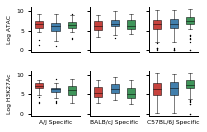

In [21]:
fig, axs = plt.subplots(2,3,figsize=(3,2),
                        sharey=True)
plt.subplots_adjust(wspace=0.2, hspace=0.4)

for i, ax in zip(['aj_intersection', 'balb_intersection', 'c57_intersection'], axs[0]):

    sns.boxplot(data=[np.log2(avg_tags_df_atac.loc[gene_list_dict[i], 'aj_atac_average']+1),
                      np.log2(avg_tags_df_atac.loc[gene_list_dict[i], 'balbcj_atac_average']+1),
                      np.log2(avg_tags_df_atac.loc[gene_list_dict[i], 'c57bl6j_atac_average']+1)],
                boxprops=dict(edgecolor=c),
                capprops=dict(color=c),
                whiskerprops=dict(color=c),
                flierprops=dict(color=c, markeredgecolor=c),
                medianprops=dict(color=c),
                palette=colors,
                width=0.5,
                linewidth=0.5,
                
                fliersize=0.5,
                ax=ax)
    ax.set_xticks([])
    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    

for i, ax in zip(['aj_intersection', 'balb_intersection', 'c57_intersection'], axs[1]):

    sns.boxplot(data=[np.log2(avg_tags_df_h3k27ac.loc[gene_list_dict[i], 'aj_h3k27ac_average']+1),
                      np.log2(avg_tags_df_h3k27ac.loc[gene_list_dict[i], 'balbcj_h3k27ac_average']+1),
                      np.log2(avg_tags_df_h3k27ac.loc[gene_list_dict[i], 'c57bl6j_h3k27ac_average']+1)],
                boxprops=dict(edgecolor=c),
                capprops=dict(color=c),
                whiskerprops=dict(color=c),
                flierprops=dict(color=c, markeredgecolor=c),
                medianprops=dict(color=c),
                palette=colors,
                width=0.5,
                linewidth=0.5,
                fliersize=0.5,
                ax=ax)
    ax.set_xticks([])
    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    axs[0,0].set_ylabel('Log ATAC')
    axs[1,0].set_ylabel('Log H3K27Ac')

    axs[1,0].set_xlabel('A/J Specific')
    axs[1,1].set_xlabel('BALB/cJ Specific')
    axs[1,2].set_xlabel('C57BL/6J Specific')
    
    
plt.savefig('./fancy_figures/atac_h3k27ac_promoter_corr.pdf',
            bbox_inches='tight')


# Check statistical differences using p values...

In [29]:
from scipy.stats import ttest_ind
from scipy.stats import wilcoxon

In [32]:
strain_dict = {'aj':'aj',
               'balb':'balbcj',
               'c57':'c57bl6j'}
for i in ['aj', 'balb', 'c57']:
    print(i+'_intersection')
    for j in ['aj', 'balb', 'c57']:
        if i != j:
            print(i, 'vs', j, 't-test')
            print(wilcoxon(avg_tags_df_atac.loc[gene_list_dict[i+'_intersection'], strain_dict[i]+'_atac_average'],
                            avg_tags_df_atac.loc[gene_list_dict[i+'_intersection'], strain_dict[j]+'_atac_average']))
    print()

aj_intersection
aj vs balb t-test
WilcoxonResult(statistic=109.0, pvalue=0.0021815615385407695)
aj vs c57 t-test
WilcoxonResult(statistic=276.0, pvalue=0.9359149665170619)

balb_intersection
balb vs aj t-test
WilcoxonResult(statistic=88.0, pvalue=1.2471023325714447e-06)
balb vs c57 t-test
WilcoxonResult(statistic=251.0, pvalue=0.0026285848460617725)

c57_intersection
c57 vs aj t-test
WilcoxonResult(statistic=7.0, pvalue=7.087259912068191e-13)
c57 vs balb t-test
WilcoxonResult(statistic=60.0, pvalue=1.5824412772185743e-11)



In [33]:
strain_dict = {'aj':'aj',
               'balb':'balbcj',
               'c57':'c57bl6j'}
for i in ['aj', 'balb', 'c57']:
    print(i+'_intersection')
    for j in ['aj', 'balb', 'c57']:
        if i != j:
            print(i, 'vs', j, 't-test')
            print(wilcoxon(avg_tags_df_h3k27ac.loc[gene_list_dict[i+'_intersection'], strain_dict[i]+'_h3k27ac_average'],
                            avg_tags_df_h3k27ac.loc[gene_list_dict[i+'_intersection'], strain_dict[j]+'_h3k27ac_average']))
    print()

aj_intersection
aj vs balb t-test
WilcoxonResult(statistic=71.0, pvalue=0.00018161179181607043)
aj vs c57 t-test
WilcoxonResult(statistic=92.0, pvalue=0.0007569203798492143)

balb_intersection
balb vs aj t-test
WilcoxonResult(statistic=80.0, pvalue=7.880498373969902e-07)
balb vs c57 t-test
WilcoxonResult(statistic=63.0, pvalue=2.8944642487941924e-07)

c57_intersection
c57 vs aj t-test
WilcoxonResult(statistic=456.0, pvalue=7.016472119889226e-06)
c57 vs balb t-test
WilcoxonResult(statistic=336.0, pvalue=1.8816659874716024e-07)

